## Install (Colab Only)

In [1]:
# download
!git clone -b main https://github.com/khalil-research/PyEPO.git
# install
!pip install PyEPO/pkg/.

# Knapsack Solution Visualization

We utilize a technique of visualizing predicted-then-optimized results in order to gain an intuitive understanding of the performance variations among the various approaches.

In this study, the knapsack problem is utilized as an exemplar.  The knapsack problem is a combinatorial optimization problem that seeks to find the most valuable set of items to include in a knapsack, subject to constraints on the total weight of the items. 

## 1 Preparation

### 1.1 Libraries

Let's import useful libraries.

In [2]:
import time
import random
import pyepo
import torch
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from torch import nn

Auto-Sklearn cannot be imported.


Then, we set the random seed for reproducibility.

In [3]:
# fix random seed
random.seed(135)
np.random.seed(135)
torch.manual_seed(135)

### 1.2 Visulization Function

Define a function that visualizes the result of the predict-then-optimize knapsack.

In [4]:
# plot function
def plotSol(m, c, w, weights, caps, caption=None):
    # colors
    cmap = cm.get_cmap("plasma")(np.linspace(0, 1, m))
    # get list
    sol, val, cap1, cap2 = [], [], [], []
    for i in range(m):
        sol.append(3)
        val.append(c[i] * w[i])
        cap1.append(weights[0,i] * w[i])
        cap2.append(weights[1,i] * w[i])
    # init fig
    fig = plt.figure(figsize=(8,4))
    plt.gca().invert_yaxis()
    acc = [0, 0, 0, 0]
    # bar plot
    for i in range(m):
        bar = [sol[i], val[i], cap1[i], cap2[i]]
        plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
        # not selected
        if not int(w[i]):
            # grey color
            bar = [sol[i], 0, 0, 0]
            plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
            plt.barh(range(4), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2, alpha=0.9)
        acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cap1[i], acc[3]+cap2[i]]
    # total value
    tval = sum(val)
    plt.text(tval+0.5, 1.1, tval, fontsize=12)
    # vertical line
    plt.axvline(x=caps[0], ymin=0.27, ymax=0.48, color="firebrick", linewidth=1.5)
    plt.text(caps[0]+0.5, 2.1, "Capacity 1", fontsize=12, color="firebrick")
    plt.axvline(x=caps[1], ymin=0.03, ymax=0.24, color="firebrick", linewidth=1.5)
    plt.text(caps[1]+0.5, 3.1, "Capacity 2", fontsize=12, color="firebrick")
    # labels and ticks
    plt.xticks([])
    plt.yticks(range(4), ["Items Selection", "Items Value", "Resource 1", "Resource 2"], fontsize=16)
    plt.minorticks_off()
    plt.tick_params(axis='both', length=0)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.title(caption, fontsize=18)
    plt.show()
    return fig

In [5]:
def visSol(reg, dataloader, optmodel, ind, title):
    # compare solutions
    for i, data in enumerate(dataloader):
        # load data
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # predict
        cp = reg(x)
        # convert to numpy
        x = x.to("cpu").detach().numpy()
        c = c.to("cpu").detach().numpy()[0]
        w = w.to("cpu").detach().numpy()[0]
        z = z.to("cpu").detach().numpy()[0]
        cp = cp.to("cpu").detach().numpy()
        if i == ind:
            # solve
            optmodel.setObj(cp[0])
            wp, _ = optmodel.solve()
            fig = plotSol(m, c, wp, weights, caps, title)
            break

### 1.3 Optimization Model, Dataset and Data Loader

#### Data Generation

We load the synthetic knapsack dataset where the weights $\mathbf{c}$ are unknown and can be predicted from features $\mathbf{x}$. Additionally, the data generator provides the weights of items. Since the constraints are fixed, the item weights are the same for all instances.

In [6]:
# generate data for 2D knapsack
m = 16 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [20] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [7]:
# data split
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

#### Optimization Model

We load a MIP model for the knapsack problem from ``pyepo.model.grb.knapsackModel``. For more details on ``optModel``, you can read tutorial [01 Optimization Model
](https://github.com/khalil-research/PyEPO/blob/main/notebooks/01%20Optimization%20Model.ipynb) and [documentation](https://khalil-research.github.io/PyEPO/build/html/content/examples/model.html).

In [8]:
optmodel = pyepo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01


#### Dataset and Data Loader

PyTorch provides ``Dataset`` to stores the samples $\mathbf{x}$ and their corresponding costs $\mathbf{c}$. Besides storing $\mathbf{x}$ and $\mathbf{c}$, ``optDataset`` uses solver to find the corresponding optimal solutions $\mathbf{w}^*$ and objective values $\mathbf{z}^*$ per instance.

More details on ``optDataset`` is [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/02%20Optimization%20Dataset.ipynb).

In [9]:
# get training data set
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
# get test data set
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 650.42it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 685.80it/s]


``DataLoader`` wraps an iterable around the Dataset to enable easy access to the samples.

In [10]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

### 1.4 PyTorch Linear Regression

In PyTorch, the ``nn.Module`` is a base class for all neural network modules in the library. It provides a convenient way to organize the layers of a model, and to define the forward pass of the model.

Here, we build the simplest PyTorch model, linear regression.

In [11]:
from torch import nn
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## 2 Solution Visualization

We present a visual representation of solutions to the knapsack problem obtained from a variety of methods. All apply to the same instance of the problem. The visualization includes four rows, with the first row depicting the items selected, the second row depicting the corresponding total values, and the last two rows displaying the capacity constraints. This visual representation serves to provide an intuitive understanding of the solutions obtained through the different methods.

In [12]:
# a index of arbitrary instance to visualize
ind = 0

Define function to train model with different methods.

In [13]:
# train model
def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)
    # train mode
    reg.train()
    for epoch in range(num_epochs):
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name == "ptb" or method_name == "pfy":
                loss = loss_func(cp, w)
            if method_name == "dbb":
                loss = loss_func(cp, c, z)
            if method_name == "2s" or method_name == "nce" or method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # log
        if epoch % 3 == 0:
            regret = pyepo.metric.regret(reg, optmodel, loader_test)
            print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))

### 2.1 Optimal Solution 

True optimal solution for current instance.

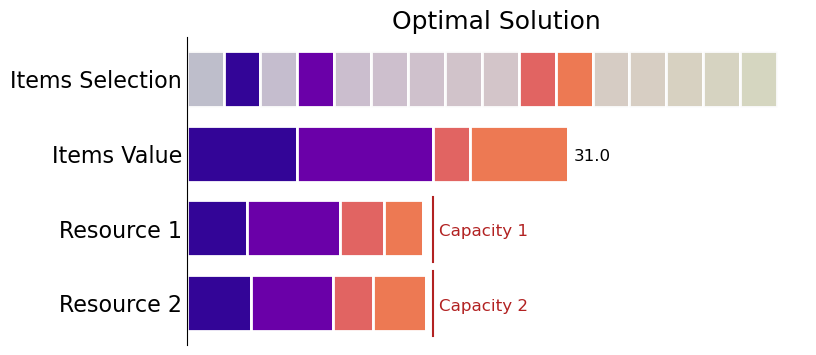

In [14]:
# compare solutions
for i, data in enumerate(loader_test):
    # load data
    x, c, w, z = data
    # convert to numpy
    x = x.to("cpu").detach().numpy()[0]
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    if i == ind:
        fig = plotSol(m, c, w, weights, caps, "Optimal Solution")
        break

### 2.2 Two-Stage with Linear Regression 

Two-stage method: train with a linear regression

In [15]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [16]:
# init MSE loss
mse = nn.MSELoss()
# train
trainModel(reg, loss_func=mse, method_name="2s")

Epoch  1,  Loss:   32.0544,  Regret: 52.1549%
Epoch  4,  Loss:  122.8351,  Regret: 43.7222%
Epoch  7,  Loss:   25.2303,  Regret: 35.8390%
Epoch 10,  Loss:   26.5294,  Regret: 29.4958%
Epoch 13,  Loss:   13.3929,  Regret: 24.4571%
Epoch 16,  Loss:   21.6398,  Regret: 21.1229%
Epoch 19,  Loss:    9.7295,  Regret: 18.5325%


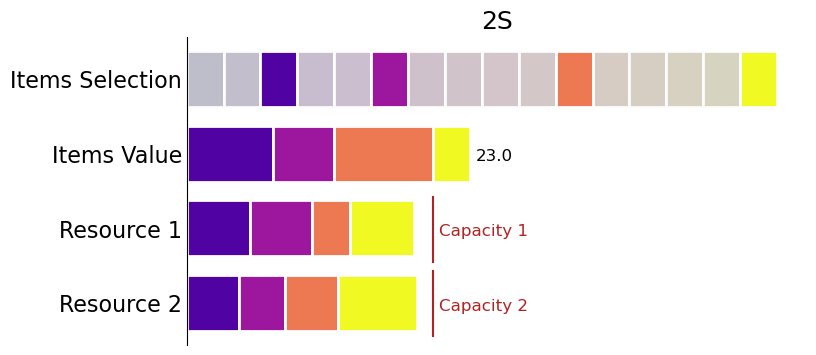

In [17]:
visSol(reg, loader_test, optmodel, ind, title="2S")

### 2.3 SPO+

Smart Predict-then-Optmize+ Loss

In [18]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [19]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(optmodel, processes=1)
# train
trainModel(reg, loss_func=spop, lr=1e-2, method_name="spo+")

Num of cores: 1
Epoch  1,  Loss:   26.6106,  Regret: 43.2699%
Epoch  4,  Loss:   30.4738,  Regret: 34.1046%
Epoch  7,  Loss:   38.8862,  Regret: 26.5092%
Epoch 10,  Loss:   20.0571,  Regret: 20.7678%
Epoch 13,  Loss:   12.0725,  Regret: 16.9588%
Epoch 16,  Loss:   19.0172,  Regret: 13.7555%
Epoch 19,  Loss:   17.7428,  Regret: 10.8511%


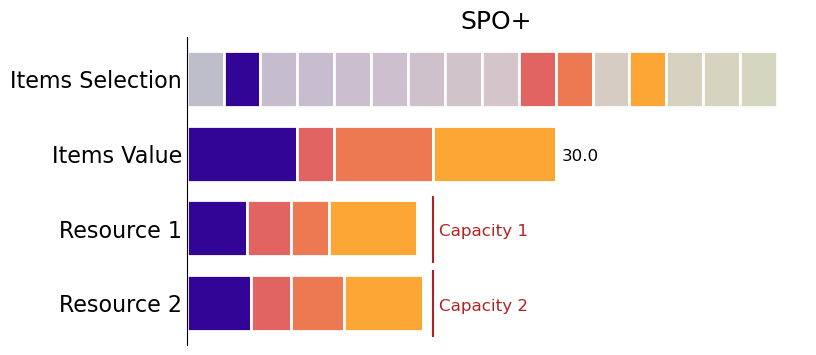

In [20]:
# compare solutions
visSol(reg, loader_test, optmodel, ind, title="SPO+")

### 2.4 DBB 

Differentiable Black-Box with Regret Loss

In [21]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [22]:
# init dbb solver
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=1) 
# set loss
l1 = nn.L1Loss()

# loss function
def dbbl1(cp, c, z):
    # black-box optimizer
    wp = dbb(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

trainModel(reg, loss_func=dbbl1, lr=1e-1, method_name="dbb")

Num of cores: 1
Epoch  1,  Loss:   10.5000,  Regret: 47.7105%
Epoch  4,  Loss:    6.5000,  Regret: 43.9502%
Epoch  7,  Loss:   13.0000,  Regret: 41.5542%
Epoch 10,  Loss:   11.2500,  Regret: 38.9003%
Epoch 13,  Loss:   10.0000,  Regret: 36.7884%
Epoch 16,  Loss:    7.7500,  Regret: 35.3045%
Epoch 19,  Loss:    2.7500,  Regret: 33.9326%


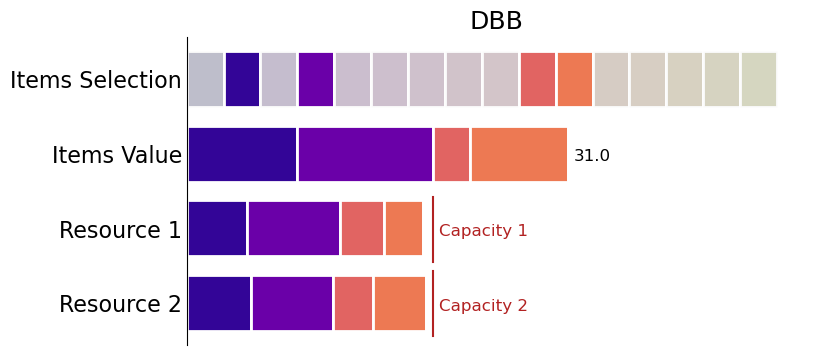

In [23]:
visSol(reg, loader_test, optmodel, ind, title="DBB")

### 2.5 DPO

Differentable Perturbated Optimizer with Regret Loss

In [24]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [25]:
# init ptb solver
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=10, sigma=0.5, processes=1)
# set loss
l1 = nn.L1Loss()

# loss function
def ptbl1(cp, w):
    # perturbed optimizer
    we = ptb(cp)
    # loss
    loss = l1(we, w)
    return loss

# train
trainModel(reg, loss_func=ptbl1, lr=5e-2, method_name="ptb")

Num of cores: 1
Epoch  1,  Loss:    0.2672,  Regret: 41.9205%
Epoch  4,  Loss:    0.3313,  Regret: 36.9342%
Epoch  7,  Loss:    0.3219,  Regret: 32.3665%
Epoch 10,  Loss:    0.3172,  Regret: 29.5481%
Epoch 13,  Loss:    0.3172,  Regret: 25.8775%
Epoch 16,  Loss:    0.2469,  Regret: 24.0534%
Epoch 19,  Loss:    0.2937,  Regret: 21.8966%


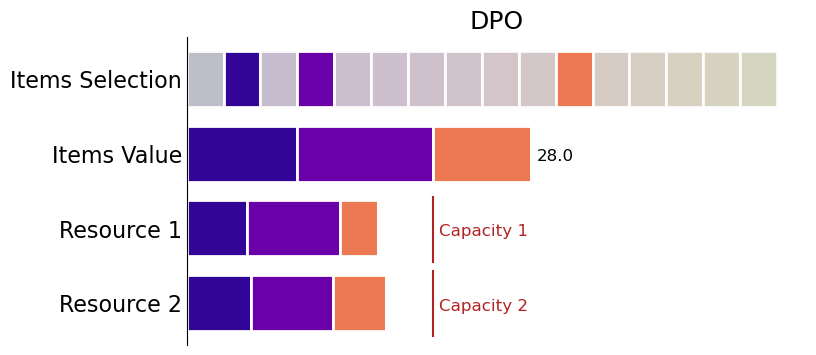

In [26]:
visSol(reg, loader_test, optmodel, ind, title="DPO")

### 2.6  PFYL

Fenchel-Young Loss with Perturbation

In [27]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [28]:
# init pfy loss
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=10, sigma=0.5, processes=1)
# train
trainModel(reg, loss_func=pfy, method_name="pfy")

Num of cores: 1
Epoch  1,  Loss:    3.9750,  Regret: 52.3642%
Epoch  4,  Loss:    2.8950,  Regret: 41.2141%
Epoch  7,  Loss:    3.0200,  Regret: 25.0776%
Epoch 10,  Loss:    2.1975,  Regret: 16.5963%
Epoch 13,  Loss:    1.8300,  Regret: 11.3782%
Epoch 16,  Loss:    1.8025,  Regret:  9.5840%
Epoch 19,  Loss:    1.7875,  Regret:  9.1466%


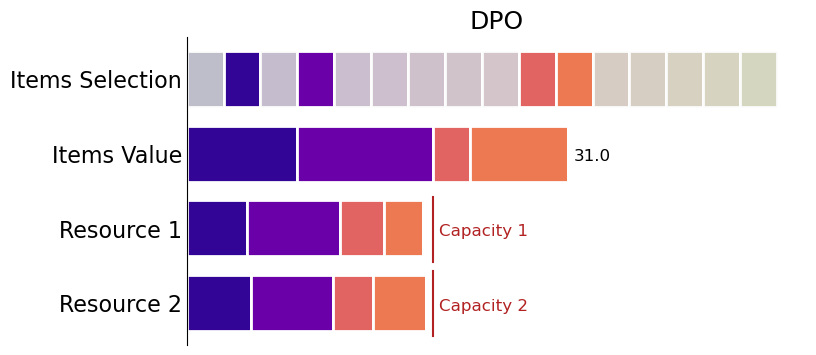

In [29]:
visSol(reg, loader_test, optmodel, ind, title="DPO")

## 2.7 NCE 

Negative Constrastive Estimation

In [30]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [31]:
# init nce loss
nce = pyepo.func.NCE(optmodel, processes=1, solve_ratio=0.10, dataset=dataset_train)
# train
trainModel(reg, loss_func=nce, lr=5e-2, method_name="nce")

Num of cores: 1
Epoch  1,  Loss:    2.1130,  Regret: 46.4284%
Epoch  4,  Loss:  -10.7881,  Regret: 54.6780%
Epoch  7,  Loss:  -99.2922,  Regret: 65.2936%
Epoch 10,  Loss:  -80.8790,  Regret: 76.1074%
Epoch 13,  Loss: -107.7289,  Regret: 82.5777%
Epoch 16,  Loss:  -69.5282,  Regret: 86.3268%
Epoch 19,  Loss:  -86.4094,  Regret: 88.1733%


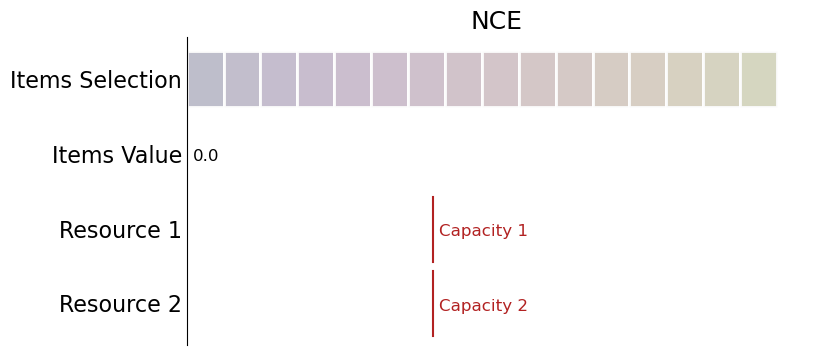

In [32]:
visSol(reg, loader_test, optmodel, ind, title="NCE")

## 2.7 LTR

Listwise Learning to Rank

In [33]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [34]:
# init ltr loss
ltr = pyepo.func.listwiseLTR(optmodel, processes=1, solve_ratio=0.10, dataset=dataset_train)
# train
trainModel(reg, loss_func=ltr, lr=5e-2, method_name="ltr")

Num of cores: 1
Epoch  1,  Loss:    0.0560,  Regret: 41.1057%
Epoch  4,  Loss:    0.0428,  Regret: 34.5307%
Epoch  7,  Loss:    0.0387,  Regret: 27.5969%
Epoch 10,  Loss:    0.0315,  Regret: 23.4291%
Epoch 13,  Loss:    0.0264,  Regret: 20.7042%
Epoch 16,  Loss:    0.0260,  Regret: 17.9232%
Epoch 19,  Loss:    0.0320,  Regret: 16.3384%


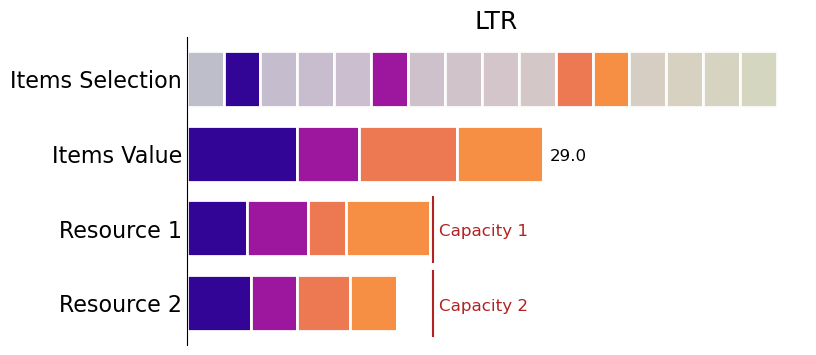

In [35]:
visSol(reg, loader_test, optmodel, ind, title="LTR")